# Features

`BGLS` supports several useful features when simulating circuits, described below.

In [1]:
"""Setup."""
import cirq

import bgls

## Simulating noisy circuits

If your `apply_op` function can apply channels, you can use `BGLS` to simulate noisy circuits through quantum trajectores. An example using `cirq.protocols.act_on`, which can apply channels, is shown below.

/home/ryan/prof/work/bgls/envbgls/lib/python3.10/site-packages/cirq/vis/state_histogram.py:103: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


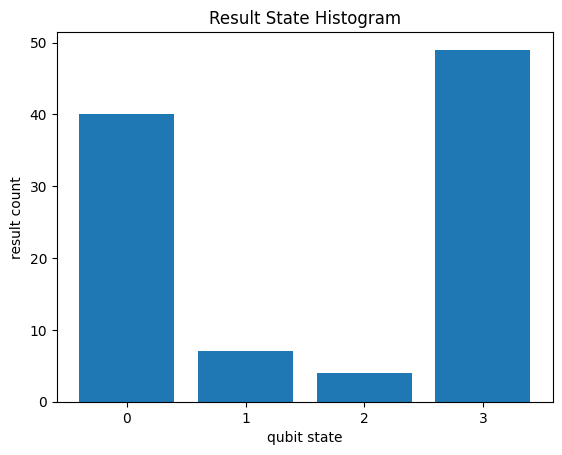

In [2]:
a, b = cirq.LineQubit.range(2)

circuit = cirq.Circuit(cirq.H.on(a), cirq.CNOT.on(a, b))
noisy = circuit.with_noise(cirq.depolarize(0.05))

sim = bgls.Simulator(
    initial_state=cirq.StateVectorSimulationState(
        qubits=(a, b), initial_state=0
    ),
    apply_op=cirq.protocols.act_on,
    compute_probability=bgls.utils.cirq_state_vector_bitstring_probability,
)

results = sim.run(noisy + cirq.measure(a, b), repetitions=100)
cirq.plot_state_histogram(results);

### How to modify `apply_op` to support channels

You can modify your `apply_op` function to support channels as follows. The simplest case is when the probability of a Kraus operator does not depend on the state. In this case, you can use the `cirq.mixture` protocol to obtain `(probability, kraus_operator)` pairs as in the example below.

In [3]:
channel = cirq.DepolarizingChannel(p=0.01)

cirq.mixture(channel)

((0.99,
  array([[1., 0.],
         [0., 1.]])),
 (0.0033333333333333335,
  array([[0.+0.j, 1.+0.j],
         [1.+0.j, 0.+0.j]])),
 (0.0033333333333333335,
  array([[0.+0.j, 0.-1.j],
         [0.+1.j, 0.+0.j]])),
 (0.0033333333333333335,
  array([[ 1.+0.j,  0.+0.j],
         [ 0.+0.j, -1.+0.j]])))

Now, you just need to select a Kraus operator according to the probability distribution and then apply it to the state. 

If the channel does not support the `cirq.mixture` protocol (i.e., if the probability of applying a Kraus operator depends on the state $|\psi\rangle$), you can still use this method by first using `cirq.kraus` to obtain the Kraus operators $K_i$ of the channel, then computing the probability of applying each channel via $p_i = \langle \psi | K_i^\dagger K_i |\psi\rangle$. 

> Note: For noiseless simulation, `BGLS` updates all bitstrings in parallel via one evolution of the state. This isn't possible in quantum trajectories because many different states are generated, so you should expect noisy simulation to be slower.

## Simulating circuits with intermediate measurements

`BGLS` can also simulate circuits with intermediate measurements without any modification.

/home/ryan/prof/work/bgls/envbgls/lib/python3.10/site-packages/cirq/vis/state_histogram.py:103: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


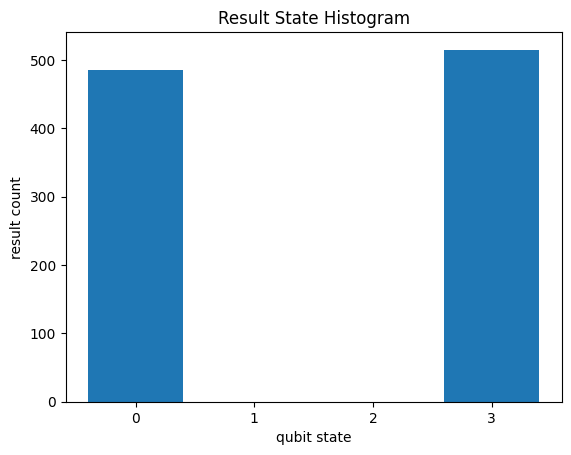

In [4]:
a, b = cirq.LineQubit.range(2)

circuit = cirq.Circuit(
    cirq.H.on(a),
    cirq.measure(a),  # <-- Intermediate measurement.
    cirq.CNOT.on(a, b),
    cirq.measure(a, b),
)

results = sim.run(circuit, repetitions=1000)
cirq.plot_state_histogram(results);

## Can I use `BGLS` with Qiskit / Pennylane / etc.?

The only accepted circuit type for `BGLS` is `cirq.Circuit`, but you can convert most popular circuit types to and from Cirq. For example, if you have a Qiskit circuit specified by the following Qasm string:

In [5]:
qasm = """
OPENQASM 2.0;
include "qelib1.inc";

qreg q[2];

h q[0];
cx q[0],q[1];"""

You can convert this to a Cirq circuit as follows.

In [6]:
from cirq.contrib.qasm_import import circuit_from_qasm

circuit_from_qasm(qasm)

q_0: ───H───@───
            │
q_1: ───────X───

This circuit can now be used with `BGLS`.